# MNIST dataset with pytorch

In [12]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

import requests
from PIL import Image
from io import BytesIO

import copy

In [13]:
number_batch = 64

# Get Dataset

In [14]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=number_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=number_batch)

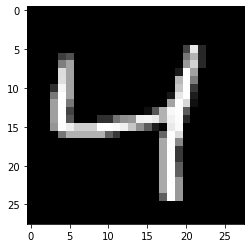

In [15]:
plt.imshow(train_data[2][0][0], cmap='gray')

# Creating Model

LeNet-5 CNN architecture

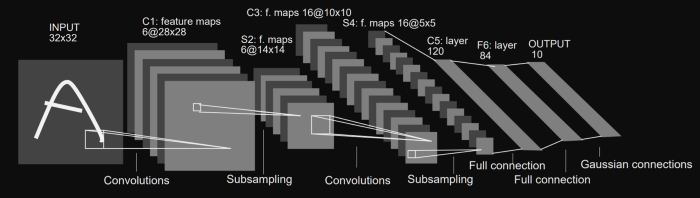

In [16]:
def create_lenet():
    model = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),#input channel 1 output channel 6
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400 , 120), #16x5x5 =500
            nn.Linear(120 , 84),
            nn.Linear(84 , 10)
    )
    return model

# Validation

In [17]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
        
    return correct*100./total
    

# Train

In [18]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
    
device

device(type='cuda', index=0)

Saving Best Model with Accuracy:  95.7699966430664
Epoch: 1 Accuracy : 95.7699966430664 %
Saving Best Model with Accuracy:  97.44000244140625
Epoch: 2 Accuracy : 97.44000244140625 %
Saving Best Model with Accuracy:  97.8499984741211
Epoch: 3 Accuracy : 97.8499984741211 %
Saving Best Model with Accuracy:  98.22000122070312
Epoch: 4 Accuracy : 98.22000122070312 %
Saving Best Model with Accuracy:  98.4800033569336
Epoch: 5 Accuracy : 98.4800033569336 %
Saving Best Model with Accuracy:  98.55999755859375
Epoch: 6 Accuracy : 98.55999755859375 %
Saving Best Model with Accuracy:  98.62000274658203
Epoch: 7 Accuracy : 98.62000274658203 %
Saving Best Model with Accuracy:  98.75
Epoch: 8 Accuracy : 98.75 %
Epoch: 9 Accuracy : 98.73999786376953 %
Saving Best Model with Accuracy:  98.77999877929688
Epoch: 10 Accuracy : 98.77999877929688 %
Epoch: 11 Accuracy : 98.5999984741211 %
Epoch: 12 Accuracy : 98.62000274658203 %
Saving Best Model with Accuracy:  98.81999969482422
Epoch: 13 Accuracy : 98.8199

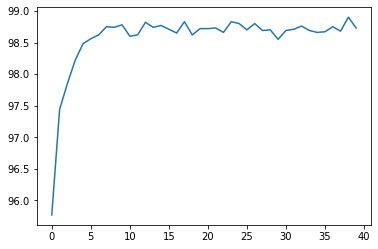

In [20]:
lenet = train(40, device=device)

In [31]:
torch.save(lenet.state_dict(), "lenet.pth")

In [32]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Linear(in_features=120, out_features=84, bias=True)
  (9): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
        
    return np.array(y_pred), np.array(y_true)
        

In [35]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [36]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,0,0,2,1
1,0,1130,0,3,0,0,0,2,0,0
2,1,3,1024,0,1,0,1,1,1,0
3,0,0,0,1003,0,2,0,0,5,0
4,1,0,1,0,964,0,1,0,0,15
5,4,0,0,7,0,878,3,0,0,0
6,7,2,0,0,1,0,944,0,3,1
7,0,2,3,1,1,1,0,1016,1,3
8,4,0,2,1,1,0,2,0,961,3
9,0,0,0,0,6,4,0,3,3,993


# Inference

In [37]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        
        return F.softmax(pred, dim=-1).cpu().numpy()

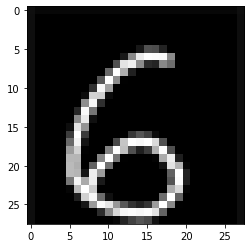

In [42]:
path = "https://apk-dl.com/detail/image/bendelac.alon.digitrecognition-w200.png"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

plt.imshow(x.squeeze(-1), cmap="gray")

In [43]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 6, Prob: 99.29931163787842 %
